Ideas:

Missing Values: Remove above threshold 

Imputation: Mean/Median, KNN, Hot/Cold-deck, RF, LR, Iterative

Anomalies: IQR removal, Winsorize, Log Transform, DBSCAN, 

Unique Values: Remove, Merge minorities

Feature Importance Early Look

Feature Engineering: Feature Importance, Manual elimiation, PCA, Interaction Terms, KNN feature, RFE, polynomial features

Categorical Encoding: One-hot, Target encoding

Target, Features Log Transform

Models: LR, CatBoost, RF, ANN, L1/L2/Elastic Net,

-5 -2: Low Sample Weights, replace with nans

Clip min target by 1 in the end

Hyperparameter Tuning

First impressions:

- Features with many missing values

- High multicollinearity between many features

- -5 and -2 oddly apppear, some bool features consist of these two, they often appear in some features with no other negative values, they correlate with missing entries: I think -5 and -2 are placeholders for missing/invalid/flawed entries  

- Many features are skewed/imbalanced as well as the target: We may need Log transforms

- CatBoost seems to be a great fit for this task as it handles missing values, categorical features, and is good agaisnt overfitting. It even has text processing features.

Method:

Due to its preliminary success (see insight notebook) I decide to move forward with CatBoost. It is very convenient to skip missing value imputation and not deal with skewness of the features and target thanks to tree based gradient boosting.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import train_test_split
from utils import *

# Setting display options for pandas
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 80)

In [ ]:
url = "https://bitbucket.org/divisionxteam/candidateschallenge/src/main/candidates_data.csv"
file = "candidates_data.csv"

replace_5_2 = True
keep_bool = False
missing_threshold = 0.3
impute = False

df = pd.read_csv(file)
# Dropping description as instructed
df = df.drop(columns="description",axis=1)
# Converting feature_1 and 2 to integers  
df["feature_1"] = df["feature_1"].str.split("_").str[1].astype(int)
df["feature_2"] = df["feature_2"].str.split("_").str[1].astype(int)

if replace_5_2:
    df = replace_special_values(df, epsilon=0.001, if_keep_bool=False)

# Drop missing features
print(f"Dropping columns with more than {missing_threshold*100}% missing values")
df = df.drop(columns=df.columns[df.isnull().mean() > missing_threshold])
column_classifications = classify_columns(df)
cat_cols = [k for k,v in column_classifications.items() if v == "Categorical"]
num_cols = [k for k,v in column_classifications.items() if (v == "Numerical") and (k!="target")]

Dropping columns with more than 30.0% missing values
(40292, 41)


Feature Selection with Recursive Feature Elimination

In [69]:
# Step 2: Select features using CatBoost's RFE feature selection
def select_features_with_catboost(train_pool, validation_pool, algorithm: EFeaturesSelectionAlgorithm, num_features: int = 20, steps: int = 5, shap_calc_type: EShapCalcType = EShapCalcType.Regular):
    print('Feature Selection Algorithm:', algorithm)
    
    model = CatBoostRegressor(random_seed=42, cat_features=cat_cols, verbose=0, eval_metric='R2',thread_count=12) #
    
    summary = model.select_features(
        train_pool,                     # Training pool
        eval_set=validation_pool,        # Validation set (instead of test set)
        features_for_select=list(range(X_train.shape[1])),   # All features considered for selection
        num_features_to_select=num_features,       # Selecting 20 features
        steps=steps,                     # Number of feature elimination steps
        algorithm=algorithm,             # Choice of algorithm: SHAP, LossFunctionChange, etc.
        shap_calc_type=shap_calc_type,   # SHAP calculation type (only used for SHAP/LossFunctionChange algorithms)
        train_final_model=False,          # Retrain model after feature selection
        plot=False,                       # Generate interactive plot
        logging_level='Silent',
        
    )
    
    print('Selected features indices:', summary['selected_features'])
    print('Selected features names:', summary['selected_features_names'])
    #print('Eliminated features indices:', summary['eliminated_features'])
    #print('Eliminated features names:', summary['eliminated_features_names'])
    return summary

df[cat_cols] = df[cat_cols].astype(int)

# Step 1: Prepare the data
X = df.drop(columns=['target'])
y = df['target']

# Split the data into train, validation, and test sets
# 70 / 15 / 15 split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# Create Pool objects for training and validation (avoid using test set for feature selection)
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
validation_pool = Pool(X_val, y_val, cat_features=cat_cols)

# Variables to store the best features and the highest R²
best_r2 = -np.inf
best_features = None

for num_features in range(15, 41, 5):
    
    # Step 3: Run feature selection with SHAP values
    shap_summary = select_features_with_catboost(
        train_pool=train_pool,
        validation_pool=validation_pool,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        num_features=num_features,
        steps=10
    )

    # Step 4: Train the final model on the selected features
    selected_features = shap_summary['selected_features']
    selected_cat_features = [df.columns[col] for col in shap_summary['selected_features'] if df.columns[col] in cat_cols]
    X_train_selected = X_train.iloc[:, selected_features]
    X_val_selected = X_val.iloc[:, selected_features]

    catboost_model = CatBoostRegressor(random_seed=42, verbose=0, cat_features=selected_cat_features)
    catboost_model.fit(X_train_selected, y_train)

    # Step 5: Evaluate the model performance on the selected features
    y_pred = catboost_model.predict(X_val_selected)

    # Calculate RMSE and R²
    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f'\nRMSE after feature selection: {rmse:.4f}')
    print(f'R² after feature selection: {r2:.4f}')
    
    # Check if this model has the best R² so far
    if r2 > best_r2:
        best_r2 = r2
        best_features = selected_features
        print(f'New best R²: {r2:.4f}, saving selected features')

# Step 6: Save the best-selected features
print(f'\nBest R²: {best_r2:.4f}')
print(f'Best selected features: {best_features}')


Feature Selection Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features indices: [0, 2, 3, 7, 11, 12, 17, 18, 21, 23, 25, 26, 27, 31, 33]
Selected features names: ['source_id', 'feature_2', 'feature_3', 'feature_7', 'feature_26', 'feature_27', 'feature_32', 'feature_33', 'feature_36', 'feature_38', 'feature_40', 'feature_41', 'feature_42', 'feature_46', 'feature_66']

RMSE after feature selection: 16244.3496
R² after feature selection: 0.8842
New best R²: 0.8842, saving selected features
Feature Selection Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features indices: [0, 2, 3, 6, 7, 11, 12, 14, 17, 18, 19, 20, 21, 25, 26, 27, 28, 31, 32, 33]
Selected features names: ['source_id', 'feature_2', 'feature_3', 'feature_6', 'feature_7', 'feature_26', 'feature_27', 'feature_29', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_46', 'feature_65', 'feature_66']

The number of features selection steps (10) is greater than the number of features to eliminate (5). The number of steps was reduced to 5.


Selected features indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37]
Selected features names: ['source_id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_65', 'feature_66', 'feature_67', 'feature_71']

RMSE after feature selection: 15888.5841
R² after feature selection: 0.8892
Feature Selection Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
Selected features indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


The number of features selection steps (10) is greater than the number of features to eliminate (0). The number of steps was reduced to 0.



RMSE after feature selection: 15959.1287
R² after feature selection: 0.8882

Best R²: 0.8940
Best selected features: [0, 2, 3, 5, 6, 7, 8, 11, 12, 16, 17, 18, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37]


CatBoost RandomSearch

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 0.8788234204
bestIteration = 749

Training on fold [1/10]

bestTest = 0.8506255368
bestIteration = 732

Training on fold [2/10]

bestTest = 0.9077099574
bestIteration = 729

Training on fold [3/10]

bestTest = 0.9324360967
bestIteration = 711

Training on fold [4/10]

bestTest = 0.849685823
bestIteration = 577

Training on fold [5/10]

bestTest = 0.7144114474
bestIteration = 745

Training on fold [6/10]

bestTest = 0.8112094433
bestIteration = 690

Training on fold [7/10]

bestTest = 0.8107300218
bestIteration = 745

Training on fold [8/10]

bestTest = 0.8650844286
bestIteration = 640

Training on fold [9/10]

bestTest = 0.8428407657
bestIteration = 749

Training on fold [0/10]

bestTest = 0.8234781078
bestIteration = 999

Training on fold [1/10]

bestTest = 0.819179069
bestIteration = 999

Training on fold [2/10]

bestTest = 0.8857289807
bestIteration = 999

Training on fold [3/10]

bestTest = 0.9025128025
bestIteration = 999

Training on fold [4/10

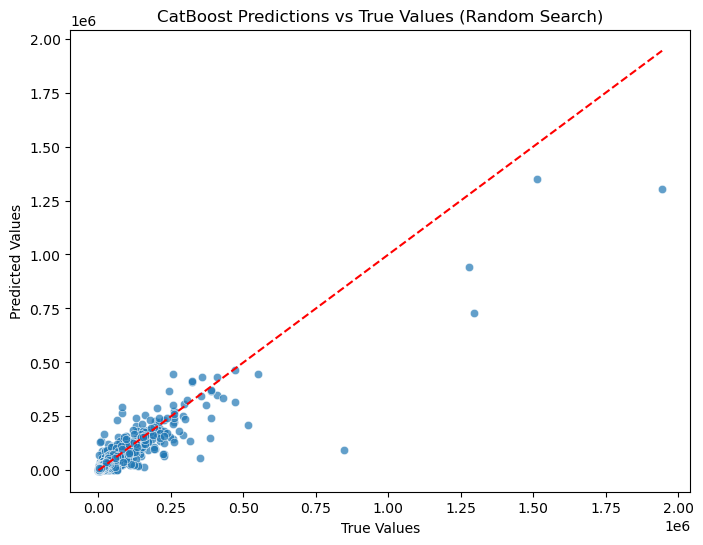

C:\Users\taylan\AppData\Local\Temp\ipykernel_19828\2057754409.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=X_train_selected.columns[sorted_idx], palette="coolwarm")


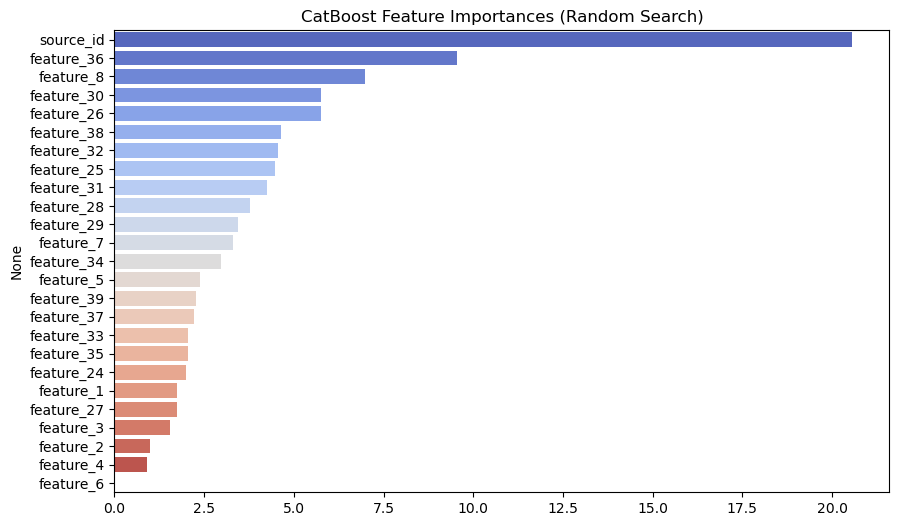

In [52]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the hyperparameter space
param_grid = {
    'iterations': [500, 750, 1000, 1250, 1500],
    'learning_rate': [0.001, 0.01, 0.03, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6, 7, 8, 9, 10, 12],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
    'random_strength': [1, 2, 5, 7, 10, 20],
    'bagging_temperature': [0.0, 0.2, 0.5, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
}

selected_features = [0, 2, 3, 5, 6, 7, 8, 11, 12, 16, 17, 18, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37] #best_features
selected_cat_features = [df.columns[col] for col in selected_features if df.columns[col] in cat_cols]
X_train_val_selected = X_train_val.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Initialize the model
catboost_model = CatBoostRegressor(random_seed=42, verbose=0,cat_features=selected_cat_features, eval_metric='R2',thread_count=12)

# Perform randomized search
randomized_search_result = catboost_model.randomized_search(
    param_grid,
    X=X_train_val_selected,
    y=y_train_val,
    n_iter=10,  # Number of parameter combinations to try
    cv=10,  
    search_by_train_test_split=False,
    #train_size=0.85,
    verbose=False,
    plot=True 
)
# Retrieve the best parameters
best_params = randomized_search_result['params']

# Train the best model using the best parameters
best_model = CatBoostRegressor(**best_params, random_seed=42, cat_features=selected_cat_features, verbose=False)
best_model.fit(X_train_val_selected, y_train_val)

# Evaluate on test set
y_pred = best_model.predict(X_test_selected)

# Calculate RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nRMSE after Random Search: {rmse:.4f}')
print(f'R² after Random Search: {r2:.4f}')

# Step 6: Plot predictions vs true values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('CatBoost Predictions vs True Values (Random Search)')
plt.show()

# Plot the feature importances for the selected features
feature_importances = best_model.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=X_train_val_selected.columns[sorted_idx], palette="coolwarm")
plt.title('CatBoost Feature Importances (Random Search)')
plt.show()

In [55]:
best_params

{'bagging_temperature': 0,
 'subsample': 0.6,
 'random_strength': 5,
 'depth': 9,
 'learning_rate': 0.1,
 'l2_leaf_reg': 3,
 'iterations': 750}


RMSE after Random Search: 20460.6817
R² after Random Search: 0.8618


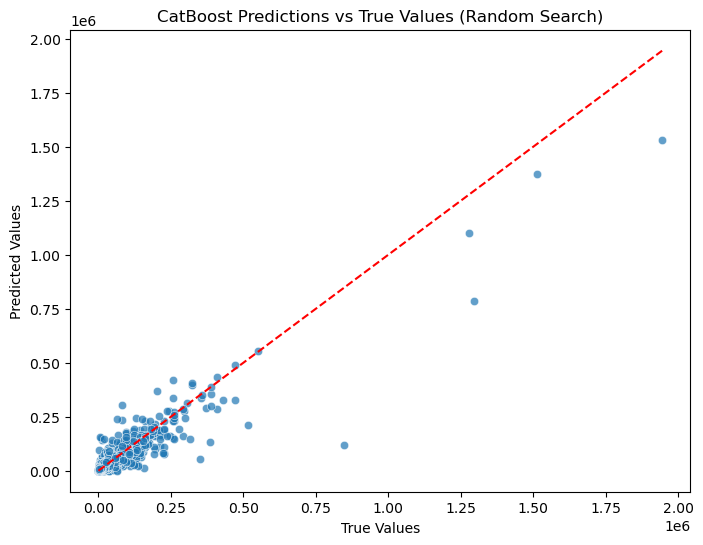

C:\Users\taylan\AppData\Local\Temp\ipykernel_19828\3557987067.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[sorted_idx], y=X_train_val_selected.columns[sorted_idx], palette="coolwarm")


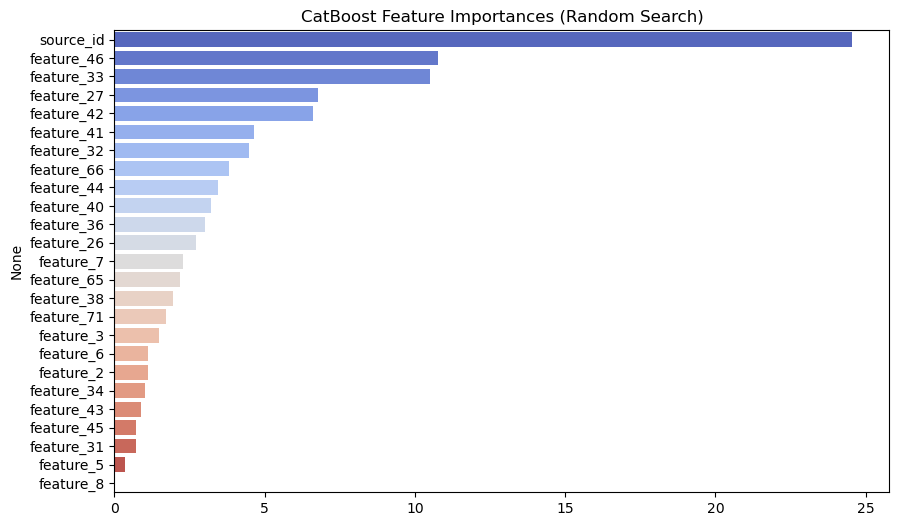

In [54]:
model = CatBoostRegressor(random_seed=42, cat_features=selected_cat_features, verbose=False)
model.fit(X_train_val_selected, y_train_val)

# Evaluate on test set
y_pred = model.predict(X_test_selected)

# Clip predictions, training data suggests target can't be smaller than 1
y_pred = np.clip(y_pred, 1, np.inf)

# Calculate RMSE and R²
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nRMSE after Random Search: {rmse:.4f}')
print(f'R² after Random Search: {r2:.4f}')

# Step 6: Plot predictions vs true values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('CatBoost Predictions vs True Values (Random Search)')
plt.show()

# Plot the feature importances for the selected features
feature_importances = model.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=X_train_val_selected.columns[sorted_idx], palette="coolwarm")
plt.title('CatBoost Feature Importances (Random Search)')
plt.show()